# Chart election winner at sportsbet

## Python set-up

In [1]:
import pandas as pd
import mgplot as mg
import numpy as np
from common import RFOOTER

In [2]:
# plotting constants
LFOOTER = (
    "Betting odds observed daily at sportsbet.com.au "
    + "(gaps = missing observations). "
)
footers = {"lfooter": LFOOTER, "rfooter": RFOOTER}
SHOW = True

In [3]:
# plotting directory set-up
def set_up_plotting() -> None:
    """Set up plotting."""

    mg.set_chart_dir("../charts/election-winner/")
    mg.clear_chart_dir()


set_up_plotting()

## Get data

In [4]:
def amalg_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Amalgamate columns into a single column (named for the first column).
    Where, for each row, only one non-NAN value exists, that value is used."""

    # --- validate inputs
    if not columns or len(columns) < 2:
        raise ValueError("Need at least 2 columns to amalgamate")

    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

    # --- check only one non-NAN value exists per row
    multi_value_rows = df[columns].notna().sum(axis=1).gt(1)
    if multi_value_rows.any():
        problem_rows = df[multi_value_rows].index.tolist()
        raise ValueError(
            f"Rows have multiple non-NaN values in columns {columns}: {problem_rows[:5]}..."
            f" (showing first 5 of {len(problem_rows)} problem rows)"
        )

    # --- amalgamate columns
    df = df.copy()  # Avoid modifying original DataFrame
    df[columns[0]] = df[columns].bfill(axis=1).iloc[:, 0]

    # --- drop the other columns
    df = df.drop(columns=columns[1:])

    print(f"Amalgamated columns {columns[1:]} into {columns[0]}")
    return df

In [5]:
def get_odds_data() -> pd.DataFrame:
    """Get the data for the election winner betting odds."""

    # --- read the data with error handling
    file_name = "../betting-data/sportsbet-2028-election-winner.csv"
    try:
        df: pd.DataFrame = pd.read_csv(file_name, index_col=0)
    except FileNotFoundError:
        raise FileNotFoundError(f"Data file not found: {file_name}")
    except pd.errors.EmptyDataError:
        raise ValueError(f"Data file is empty: {file_name}")

    # --- handle mixed column formats (old data uses variable/value, new uses Party/Odds)
    if "variable" in df.columns and "value" in df.columns:
        # Old format - rename columns for consistency
        df = df.rename(columns={"variable": "Party", "value": "Odds"})
    elif "Party" in df.columns and "Odds" in df.columns:
        # New format - already correct
        pass
    else:
        raise ValueError(
            f"Unexpected CSV format. Expected 'Party' and 'Odds' columns, got: {list(df.columns)}"
        )

    # --- validate data
    if df.empty:
        raise ValueError("No data found in CSV file")

    if df["Odds"].isnull().all():
        raise ValueError("All odds values are null")

    # Check for negative odds
    numeric_odds = pd.to_numeric(df["Odds"], errors="coerce")
    if (numeric_odds < 0).any():
        raise ValueError("Negative odds detected in data")

    # --- pivot and process data
    try:
        df = df.pivot(columns="Party", values="Odds")
    except ValueError as e:
        raise ValueError(f"Error pivoting data: {e}")

    # Convert to PeriodIndex and remove duplicates
    try:
        df.index = pd.PeriodIndex(df.index, freq="D")
        df = df[~df.index.duplicated(keep="first")].sort_index()
    except Exception as e:
        raise ValueError(f"Error processing date index: {e}")

    # --- column amalgamations (manage data discontinuities)
    amalg_set = [
        ["Liberal and/or Nationals", "Coalition"],
        # add as needed
    ]
    for columns in amalg_set:
        # Only amalgamate if both columns exist
        existing_columns = [col for col in columns if col in df.columns]
        if len(existing_columns) > 1:
            df = amalg_columns(df, existing_columns)

    # --- fill in missing dates - this will be useful for plotting
    if len(df) > 0:
        new_index = pd.period_range(start=df.index.min(), end=df.index.max(), freq="D")
        df = df.reindex(new_index, fill_value=None)

    # --- print tail of "Any Other Result" then drop the column
    remove = "Any Other Result"
    if remove in df.columns:
        print(remove, "\n", df[remove].tail())
        df = df.drop(columns=remove, errors="ignore")

    # --- final validation
    if df.empty:
        raise ValueError("No data remaining after processing")

    # Convert odds to numeric, replacing any non-numeric values with NaN
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    print(
        f"Successfully loaded data with {len(df)} rows and {len(df.columns)} parties: {list(df.columns)}"
    )
    return df


core_odds = get_odds_data()

Amalgamated columns ['Coalition'] into Liberal and/or Nationals
Any Other Result 
 2025-11-07    51.0
2025-11-08    51.0
2025-11-09    51.0
2025-11-10    51.0
2025-11-11    51.0
Freq: D, Name: Any Other Result, dtype: float64
Successfully loaded data with 189 rows and 2 parties: ['Labor', 'Liberal and/or Nationals']


## Make some charts

In [6]:
def limit_data(df: pd.DataFrame, start: int | pd.Period) -> pd.DataFrame:
    """Limit the data to a specific start date or index."""

    if isinstance(start, int):
        this_data = df.iloc[start:]
    else:
        this_data = df.loc[df.index >= start]

    return this_data

Plotting odds for 2 parties: ['Labor', 'Liberal and/or Nationals']


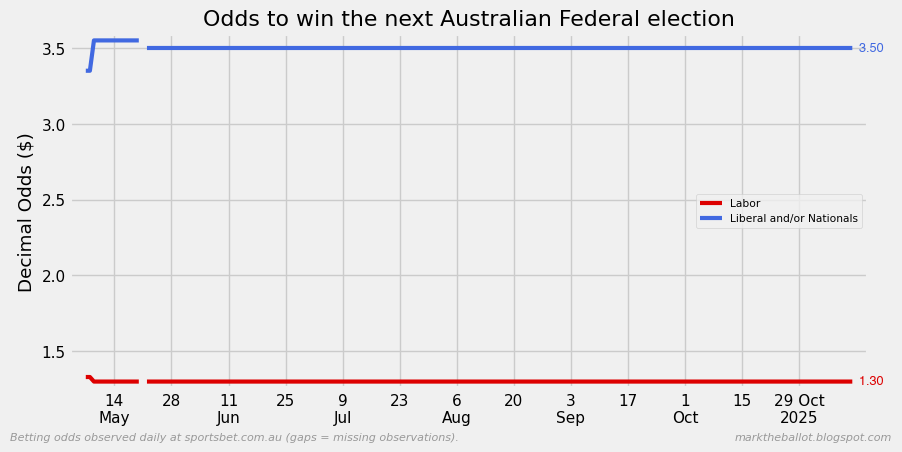

In [7]:
def plot_party_odds(
    df: pd.DataFrame,
    starts: tuple[int | pd.Period, ...] = (0,),
) -> None:
    """
    Plot the party odds to win the next Australian Federal election.
    """

    # --- validate input
    if df.empty:
        print("Warning: No data to plot for party odds")
        return

    if df.isnull().all().all():
        print("Warning: All data is null, cannot create odds plot")
        return

    # Check if we have any columns to plot
    valid_columns = [col for col in df.columns if not df[col].isnull().all()]
    if not valid_columns:
        print("Warning: No valid data columns found for plotting")
        return

    print(f"Plotting odds for {len(valid_columns)} parties: {valid_columns}")

    colors = mg.colorise_list(df.columns)
    mg.multi_start(
        df,
        function=mg.line_plot_finalise,
        starts=starts,
        color=colors,
        title="Odds to win the next Australian Federal election",
        xlabel=None,
        ylabel="Decimal Odds ($)",
        legend=True,
        width=3,
        annotate=True,
        rounding=2,
        dropna=False,
        **footers,
        show=SHOW,
    )


plot_party_odds(core_odds)

In [8]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    """
    Convert decimal odds to adjusted probabilities
    (ie, scaled to sum to one; addressing the bookmaker's over-round).
    """

    # --- validate input
    if odds.empty:
        raise ValueError("Cannot convert empty odds DataFrame")

    # Check for non-positive odds
    if (odds <= 0).any().any():
        print(
            "Warning: Found non-positive odds values, these will be excluded from probability calculations"
        )
        odds = odds.where(odds > 0)  # Replace non-positive with NaN

    # Check if we have any valid data after filtering
    if odds.isnull().all().all():
        raise ValueError("No valid positive odds found for probability conversion")

    # get raw probabilities (1/odds)
    with np.errstate(divide="ignore", invalid="ignore"):
        raw_probs = 1 / odds

    # remove the bookmakers over-round
    # Only calculate for rows that have at least 2 non-null values
    total = raw_probs.sum(axis=1)

    # Check for rows with zero or very small totals
    valid_rows = total > 1e-10
    if not valid_rows.any():
        raise ValueError(
            "No valid probability calculations possible - all row totals are zero or too small"
        )

    probability = raw_probs.div(total, axis=0)

    # Convert to percentage
    result = probability * 100

    # Report statistics
    valid_data_points = result.notna().sum().sum()
    total_data_points = result.size
    print(
        f"Probability conversion: {valid_data_points}/{total_data_points} valid data points"
    )

    return result


adj_probs = convert(core_odds)

Probability conversion: 376/378 valid data points


Plotting probabilities for 2 parties: ['Labor', 'Liberal and/or Nationals']


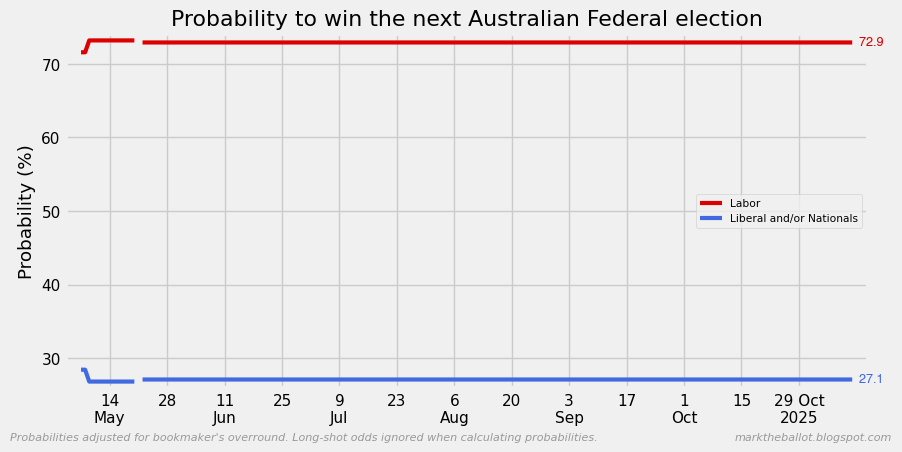

In [9]:
def plot_probabilities(
    df: pd.DataFrame,
    starts: tuple[int | pd.Period, ...] = (0,),
) -> None:
    """Plot the adjusted probabilities of winning the next election."""

    # --- validate input
    if df.empty:
        print("Warning: No data to plot for probabilities")
        return

    if df.isnull().all().all():
        print("Warning: All probability data is null, cannot create plot")
        return

    # Check if we have any columns to plot
    valid_columns = [col for col in df.columns if not df[col].isnull().all()]
    if not valid_columns:
        print("Warning: No valid probability columns found for plotting")
        return

    print(f"Plotting probabilities for {len(valid_columns)} parties: {valid_columns}")

    colors = mg.colorise_list(df.columns)
    lfooter = (
        "Probabilities adjusted for bookmaker's overround. "
        "Long-shot odds ignored when calculating probabilities. "
    )
    mg.multi_start(
        df,
        function=mg.line_plot_finalise,
        starts=starts,
        color=colors,
        title="Probability to win the next Australian Federal election",
        xlabel=None,
        ylabel="Probability (%)",
        legend=True,
        width=3,
        annotate=True,
        rounding=1,
        dropna=False,
        lfooter=lfooter,
        rfooter=RFOOTER,
        show=SHOW,
    )


plot_probabilities(adj_probs)

## Finished

In [10]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-11-11 06:37:22

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.6.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

numpy : 2.3.4
mgplot: 0.2.12
pandas: 2.3.3

Watermark: 2.5.0



In [11]:
print("It is done")

It is done
